## Trend Example 1

In [1]:
import sys
import os

sys.path.append(
    os.path.abspath(
        os.path.join(os.path.dirname(os.path.realpath("__file__")), "..", "..")
    )
)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
from visualization.figure import Figure
import visualization.charts as charts

### Create fake data

In [5]:
rf = 0.04
np.random.seed(1)
mus = np.random.normal(loc=0.05, scale=0.02, size=5) + rf
sigmas = (mus - rf) / 0.3 + np.random.normal(loc=0.0, scale=0.01, size=5)

num_years = 10
num_months_per_year = 12
num_days_per_month = 21
num_days_per_year = num_months_per_year * num_days_per_month

rdf = pd.DataFrame(
    index=pd.date_range(
        start="2008-01-02",
        periods=num_years * num_months_per_year * num_days_per_month,
        freq="B",
    ),
    columns=["foo", "bar", "baz", "fake1", "fake2"],
)

for i, mu in enumerate(mus):
    sigma = sigmas[i]
    rdf.iloc[:, i] = np.random.normal(
        loc=mu / num_days_per_year,
        scale=sigma / np.sqrt(num_days_per_year),
        size=rdf.shape[0],
    )
pdf = np.cumprod(1 + rdf) * 100
test = pdf.reset_index(names="DATE")

### Create Trend signal over the last 12 months

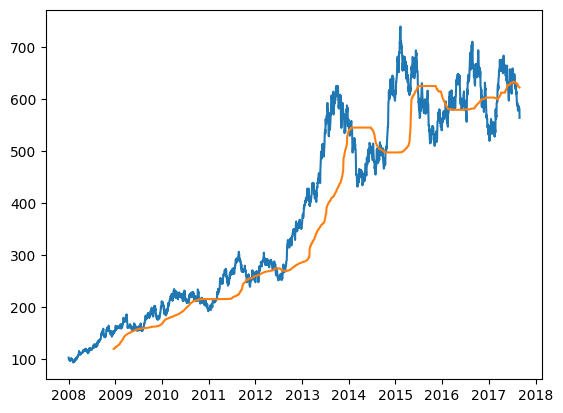

In [ ]:
sma = pdf.rolling(window=num_days_per_month * 12, center=False).median().shift(1)
plt.plot(pdf.index, pdf["foo"])
plt.plot(sma.index, sma["foo"])
plt.show()

In [ ]:
# target weights
trend = sma.copy()
trend[pdf > sma] = True
trend[pdf <= sma] = False
trend[sma.isnull()] = False
trend.tail()

/var/folders/sc/dbchfm_s3kv6pz1zshqjcn640000gn/T/ipykernel_12889/599213171.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  trend[pdf > sma] = True


,foo,bar,baz,fake1,fake2
2017-08-23,False,True,True,True,True
2017-08-24,False,True,True,True,True
2017-08-25,False,True,True,True,True
2017-08-28,False,True,True,True,True
2017-08-29,False,True,True,True,True


Compare EW and 1/vol

Both strategies rebalance daily using trend with 1 day lag and weights limited to 40%.

In [ ]:
from bt.core import Strategy
from bt.algos.flow import RunDaily
from bt.algos.selection import SelectWhere
from bt.algos.weighting import WeighInvVol, WeighEqually, LimitWeights
from bt.algos.portfolio_ops import Rebalance
from bt.engine import Backtest
import bt

In [ ]:
tsmom_invvol_strat = Strategy(
    "tsmom_invvol",
    [
        RunDaily(),
        SelectWhere(trend),
        WeighInvVol(),
        LimitWeights(limit=0.5),
        Rebalance(),
    ],
)

tsmom_ew_strat = Strategy(
    "tsmom_ew",
    [
        RunDaily(),
        SelectWhere(trend),
        WeighEqually(),
        LimitWeights(limit=0.5),
        Rebalance(),
    ],
)

In [ ]:
# create and run
tsmom_invvol_bt = Backtest(
    tsmom_invvol_strat,
    pdf,
    initial_capital=50000000.0,
    commissions=lambda q, p: max(100, abs(q) * 0.0021),
    integer_positions=False,
    progress_bar=True,
)
tsmom_invvol_res = bt.run(tsmom_invvol_bt)

tsmom_ew_bt = Backtest(
    tsmom_ew_strat,
    pdf,
    initial_capital=50000000.0,
    commissions=lambda q, p: max(100, abs(q) * 0.0021),
    integer_positions=False,
    progress_bar=True,
)
tsmom_ew_res = bt.run(tsmom_ew_bt)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:03<00:00,  3.02s/it]


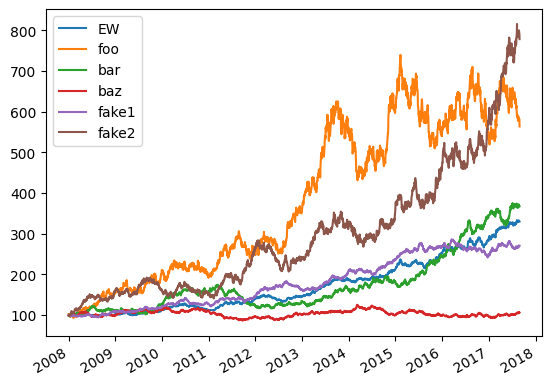

In [ ]:
ax = plt.subplot()
ax.plot(tsmom_ew_res.prices.index, tsmom_ew_res.prices, label="EW")
pdf.plot(ax=ax)

ax.legend()
plt.legend()
plt.show()

In [ ]:
tsmom_ew_res.stats

,tsmom_ew
start,2008-01-01 00:00:00
end,2017-08-29 00:00:00
rf,0.0
total_return,2.300043
cagr,0.131571
max_drawdown,-0.128013
calmar,1.027792
mtd,0.017549
three_month,0.040739
six_month,0.083428
